In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)


32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


11897


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break


      0/ 200000: 3.3135


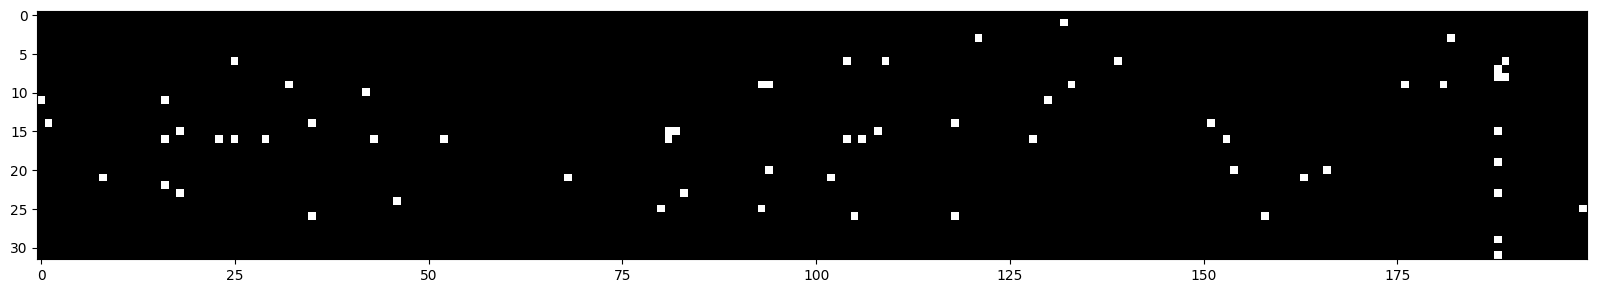

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')


(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

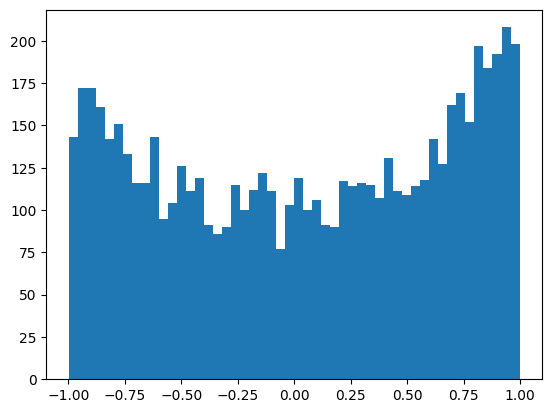

In [ ]:
plt.hist(h.view(-1).tolist(), 50)


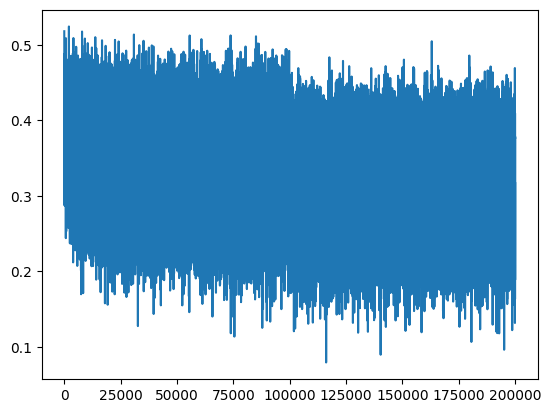

In [ ]:
plt.plot(lossi)


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0698277950286865
val 2.130896806716919


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        hpreact = x @ W1 + b1
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decode and print the generated word


carmah.
amelle.
khi.
mili.
taty.
skanden.
jazon.
nadelynn.
jareei.
nellara.
chaiivia.
leigh.
ham.
jory.
quint.
salin.
alianni.
wazelo.
dearisi.
jaxen.
